In [ ]:
from __future__ import division, unicode_literals, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os.path, os, sys, json
import nglview
import mdtraj as md
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 6.0]})
workdir=%pwd
print(workdir)

### Monte Carlo simulations using _Faunus_

To simulate magnetic particles interacting on a plane we use a custom Metropolis Monte Carlo (MC) program built within the [Faunus framework](https://mlund.github.io/neofaunus/docs/). 

### Run Metropolis Monte Carlo Simulation

 run it and print simulation details.
Finally, the positions at the end of the simulation are visualized.

Our system is a cubic box of side length $L$ where $N$ particles translate in the x- and y-directions.

Particles interact via $\propto$ r$^{-12}$ and $\propto$ r$^{-3}$ pair-potentials. 
The $\propto$ r$^{-12}$ potential, modelling the exchange repulsions between finite-size particles, is given by

\begin{equation}
u_{rep}(r) = E \frac{\sigma^{12}}{r^{12}}
\end{equation}
where $\sigma$ is the particle's diameter, and $E$ is an energy parameter.

The $\propto$ r$^{-3}$ potential, modelling the magnetic dipole-dipole interaction, reads as

\begin{equation}
u_{d-d}(r) = \frac{C}{r^{3}}
\end{equation}

where C is a constant proportional to the squared magnitude of the particle's magnetic dipole moment (page 83 [Israelachvili](http://www.sciencedirect.com/science/book/9780123751829)).

In molecular simulations, the boundary effects related to the small size of the simulation box compared to bulk systems is very often handled using periodic boundary conditions (PBC): any particle passing through one boundary of the simulation cell comes back into the cell through the opposite boundary (page 34 [Frenkel & Smit](http://www.sciencedirect.com/science/book/9780122673511)).

If we do not use PBC in our simulation, our system would be confined by hard walls corresponding to the repulsive magnetic bars at the sides of the 2D particle simulator.

### Run Metropolis Monte Carlo Simulation

This will generate an input file for the MC program, run it and print simulation details.
Finally, the positions at the end of the simulation are visualized.

In [ ]:
mcdir = workdir+'/faunus/src/examples'
%cd $mcdir
%rm -f state

N=40          # number of particles
diameter=30   # particle diameter
L=600.        # side lengths of the quadratic simulation plane
C=1.5e6       # constant proportional to the squared magnitude of the particle's magnetic dipole moment
E=10          # energy parameter for exclusion repulsion

# generate input file for MC program
js = {
    "atomlist" : { "MP" : { "r":diameter*0.5, "dp":100 } },
    "moleculelist" : {
        "myparticles" : { "atoms":"MP", "atomic":True, "Ninit" : N, "insdir":"1 1 0" }
    },
    "energy" : {
        "nonbonded" : {
            "repulsionr3" : {"prefactor":C, "lj-prefactor":E, "sigma":diameter}
        }
    },
    "moves" : {
        "atomtranslate" : {
          "myparticles" : { "peratom":True, "dir":"1 1 0" }
        }
    },
    "system" : {
        "cuboid" : { "len" : L }
    }
}
with open('montecarlo.json', 'w+') as f:
    f.write(json.dumps(js, indent=4))

# if MC executable exists, run it and visualize final configuration
exe='./stripes'
if ( os.access( exe, os.X_OK )):
    !./stripes
    x,y = np.genfromtxt('confout.pqr', invalid_raise=False, usecols=(5,6), unpack=True, skip_footer=1)
    x=x+L/2.0
    y=y+L/2.0
    plt.plot(x,y, 'ro', ms=diameter*0.5)
    plt.xlabel(r'(you fill in all axis labels!)')

This will generate an input file for the MC program to simulate the system with PBC

In [16]:
%%writefile pbc.yml
temperature: 298
mcloop: {macro: 10, micro: 1000}
geometry: {length: 600.}
energy:
    - nonbonded:
        default:
            - repulsionr3: {prefactor: 1.5e6, lj-prefactor: 10, sigma: 30}
atomlist:
    - MP: {dp: 100} 
moleculelist:
    - magnets: {atoms: [MP], atomic: true, insdir: [1,1,0]}
insertmolecules:
    - magnets: {N: 40}
moves:
    - transrot: {molecule: magnets, dir: [1,1,0]}
analysis:
    - atomrdf: {file: rdf.dat, nstep: 10, dr: 0.1, name1: MP, name2: MP}
    - systemenergy: {file: energy.dat, nstep: 10}
    - xtcfile: {file: traj.xtc, nstep: 10}
    - savestate: {file: confout.pqr}
    - savestate: {file: state}
    - density: {nstep: 10}

Overwriting input.yml


This will generate an input file for the MC program to simulate the system without PBC

In [77]:
%%writefile nopbc.yml
temperature: 298
mcloop: {macro: 10, micro: 100}
geometry: {length: 600.}
energy:
    - nonbonded:
        default:
            - repulsionr3: {prefactor: 1.5e6, lj-prefactor: 10, sigma: 30}
    - confine: {type: cuboid, low: [-300,-300,0], high: [300,300,0], molecules: [magnets], k: 1e8}
atomlist:
    - MP: {sigma: 30, dp: 100} 
moleculelist:
    - magnets: {atoms: [MP], atomic: true, insdir: [1,1,0]}
insertmolecules:
    - magnets: {N: 40}
moves:
    - transrot: {molecule: magnets, dir: [1,1,0]}
analysis:
    - atomrdf: {file: rdf.dat, nstep: 10, dr: 0.1, name1: MP, name2: MP}
    - systemenergy: {file: energy.dat, nstep: 10}
    - xtcfile: {file: traj.xtc, nstep: 10}
    - savestate: {file: config.gro}
    - savestate: {file: config.pqr}
    - savestate: {file: state}
    - density: {nstep: 10}

Overwriting nopbc.yml


This will generate an input file for the MC program to simulate the system with PBC

In [ ]:
!yason.py pbc.yml | faunus

This will generate an input file for the MC program to simulate the system without PBC

In [78]:
!yason.py nopbc.yml | faunus_nopbc

/Users/giulio/miniconda3/envs/particletracking/bin/yason.py:53: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel_yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel_yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  d = yaml.load( i )
[======================================================================] 100% 0.2ss
relative drift = 7.31595e-16


/Users/giulio/miniconda3/envs/particletracking/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


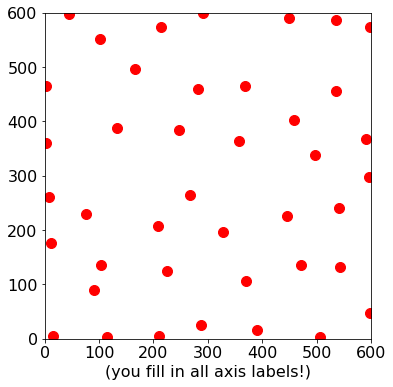

In [79]:
x,y = np.genfromtxt('config.pqr', invalid_raise=False, usecols=(5,6), unpack=True, skip_footer=1)
plt.plot(x,y, 'ro', ms=10)
plt.xlabel(r'(you fill in all axis labels!)')
plt.ylim(0,600)
plt.xlim(0,600)
plt.axes().set_aspect('equal')

In [30]:
view = nglview.show_file('config.gro')
view

NGLWidget()

In [31]:
traj = md.load_xtc('traj.xtc',top='config.gro')
print(traj.n_atoms)
view = nglview.show_mdtraj(traj)
view.add_unitcell()
#view.camera='orthographic'
#view.add_point()
#view.add_ball_and_stick()
view.add_representation('point',color='blue',selection='name MP')
view

40


NGLWidget(count=100)

### Calculate histogram for uniform distribution (Hard Walls)

We now generate the distribution of particle distances for the case where these are completely uncorrelated, i.e. for an ideal 2D gas confined on a square with hard boundaries. This is done by randomly placing a large number of particles (the more, the higher accuracy) and build a histogram of distances.

In [ ]:
from scipy.spatial import distance
ux = np.random.random_integers(0, L, 5000)
uy = np.random.random_integers(0, L, 5000)
upos = np.array([ux, uy]).T
hist = np.histogram(distance.pdist(upos), bins=150, normed=True)
ur = hist[1][1:]# / diameter
uP = hist[0]

### Load simulated histogram

During simulation, the MC program samples the distribution of distances observed and saves it to the file `hist.dat`.
This we here load, normalize and plot.

In [ ]:
r,P = np.loadtxt('hist.dat', unpack=True)
r = r
ur = hist[1][1:]
print(L)
P = P/P.cumsum()[-1] # normalize
plt.plot(r, P,lw=2)
plt.plot(ur, uP,lw=2)
plt.show()

### Calculate histogram for uniform distribution (PBC with minimum image convention)

We now generate the distribution of particle distances for the case where these are completely uncorrelated, i.e. for an ideal 2D gas with PBC using the minimum image convention. This is done by randomly placing a large number of particles (the more, the higher accuracy) and build a histogram of distances.

In [ ]:
from scipy.spatial import distance
ux = np.random.randint(0, L+1, 2000)
uy = np.random.randint(0, L+1, 2000)
upos = np.array([ux, uy]).T
def minimum_image(u,v): # calculate distance according to minimum image convention
    dvec = np.absolute(u-v)
    d2 = 0
    for i in dvec:
        if (i>L/2):
            d2 += (i-L)**2
        else:
            d2 += i**2
    return np.sqrt(d2)
hist = np.histogram(distance.pdist(upos,lambda u, v: minimum_image(u,v)), bins=150, normed=True)
urpbc = hist[1][1:]# / diameter
uPpbc = hist[0]

### Load simulated histogram

During simulation, the MC program samples the distribution of distances observed and saves it to the file `histpbc.dat`.
This we here load, normalize and plot.

In [ ]:
rpbc,Ppbc = np.loadtxt('histpbc.dat', unpack=True)
r = r
ur = hist[1][1:]
print(L)
Ppbc = Ppbc/Ppbc.cumsum()[-1] # normalize
plt.plot(rpbc, Ppbc,'r-',lw=2, label='MC with PBC')
plt.plot(urpbc, uPpbc,'b-',lw=2, label='Uncorrelated\npoint particles')
plt.ylim(-.0001,0.0061)
plt.legend(frameon=False,loc='upper left')
plt.show()

### Calculate final distribution function, $g(r)$

In order to divide the two above distributions with each other, the data points in each set need to be aligned. This we easily ensure with Akima splines.

In [ ]:
from scipy.interpolate import Akima1DInterpolator
rvals = np.linspace(0,L+80,500)
gofr = Akima1DInterpolator(r, P)(rvals) / Akima1DInterpolator(ur, uP)(rvals)
gofrpbc = Akima1DInterpolator(rpbc, Ppbc)(rvals) / Akima1DInterpolator(urpbc, uPpbc)(rvals)
plt.plot(rvals, gofr, 'r-',lw=2,label='MC with hard walls')
plt.plot(rvals, gofrpbc, 'b-',lw=2,label='MC with PBC')
plt.plot([0,700],[1,1],'k--',lw=0.5)
plt.ylim(-0.1,3.1)
plt.legend(frameon=False)

### Calculate average energy 

Integrate the pair potential over the volume around a test particle weighting by the radial distribution function:

In [ ]:
rvals = np.linspace(0.85,L/2,500)
gofr = Akima1DInterpolator(r, P)(rvals) / Akima1DInterpolator(ur, uP)(rvals)
area=L*L
dr = rvals[1]-rvals[0]
print( np.cumsum(dr*math.pi*rvals*gofr)[-1] * N**2 / area )

### Exercises, Part II

0. For all figures, label axes specifying the units.
0. Explore the particle displacement parameter. How does this influence the mean square displacement and move acceptance? Does it influence the final result?
0. How does temperature enter the simulation?
0. Run simulation with PBC instead of hard walls (change CuboidNoPBC to Cuboid in line 4, hist.dat to histpbc.dat, in montecarlo.cpp and recompile).
0. Observe the  distance distribution, $P(r)$, for magnetic particles in a 2D system of side length 600 pixels, with PBC. Why does $P(r)$ increase linearly with $r$ for $r<300$ pixels? What $r$-dependence would you expect for a 3D system? (Hint: Read paragraph 17-1 in Hill's book - especially page 301. Please mention the difference between the infinitesimal area and volume elements in 2D and 3D, respectively.)
0. Observe the radial distribution functions, RDF or $g(r)$, obtained from the 2D particle simulator and from MC simulations of magnetic particles, with and without PBC. Comment on the differences between the three RDFs, and explain the deviation from unity at large separations observed in the simulation result (with and without PBC) and for the 2D particle simulator.  (Hint: In the 2D particle simulator the walls are magnetic bars, not just hard walls.)
0. Simulate $g(r)$ for non-interacting particles (N.B. both dipole-dipole and size-exclusion interactions should be vanishing). Although in theory it should, the curve may not be unity for all distances. Why?
0. List the differences between the particle simulator and the MC system. (Hint: discuss at least boundaries, interactions).
0. Complete the script in the last cell of the notebook to calculate the average energy of the system with the following integral:

\begin{equation}
\bar{U} = \frac{N^2}{2A} \int_0^\infty \mathrm{d}r 2\pi r \left ( u_{rep}(r) + u_{d-d}(r) \right ) g(r)
\end{equation}